Ensure latest version of package is installed

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# only run if you need to clone, make sure you have a "cs260d" folder
%cd /content/drive/MyDrive/cs260d
!git clone https://github.com/sjoshi804/sas-data-efficient-contrastive-learning.git

In [ ]:
%cd /content/drive/MyDrive/cs260d/sas-data-efficient-contrastive-learning

/content/drive/MyDrive/cs260d/sas-data-efficient-contrastive-learning


In [ ]:
# theres gonna be some errors, you need to resolve them
# might need to run this twice for some reason
%pip install -r requirements.txt

In [ ]:
%pip install sas-pip/

Processing ./sas-pip
  Preparing metadata (setup.py) ... done
  Created wheel for sas: filename=sas-1.0-py3-none-any.whl size=6289 sha256=328451b1e42f3b604a9f2f03caaf24f41d3cca82cdceeda317538d56f5d47acd
  Stored in directory: /root/.cache/pip/wheels/4c/d9/f7/37d9fa72f2ae791266a55a1506d6be74d4860a6bfbc324ced7
Successfully built sas
  Attempting uninstall: sas
    Found existing installation: sas 1.0
    Uninstalling sas-1.0:
      Successfully uninstalled sas-1.0


Load Data

In [ ]:
# restart the kernel if errors appear here
import torchvision
from torchvision import transforms

clean_cifar100 = torchvision.datasets.CIFAR100("/data/cifar100/", transform=transforms.ToTensor(), download=True)
device = "cuda:0"

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /data/cifar100/cifar-100-python.tar.gz to /data/cifar100/


add noise to dataset

In [ ]:
import matplotlib.pyplot as plt
import torch

from PIL import Image, ImageFilter

# functions to transfer between pil object and tensor
transform_to_pil = transforms.ToPILImage()
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

def gaussian_blur(x):
  x = transform_to_pil(x)
  im2 = x.filter(ImageFilter.GaussianBlur(radius=4))
  res = transform_to_tensor(im2)

  return res

def gaussian_noise(x):
  a, b, c = x.shape
  d = torch.randn(a, b, c) * .3

  return x + d


def plt2(i, i2):
  """Display two images."""
  fig = plt.figure(figsize=(10, 7))

  # setting values to rows and column variables
  rows = 2
  columns = 1

  fig.add_subplot(rows, columns, 1)

  plt.imshow(i)
  fig.add_subplot(rows, columns, 2)

  plt.imshow(i2)

In [ ]:
# choose noisy indices
import random

percent_noisy = .1
noisy_indices = random.sample(range(1, len(clean_cifar100)), int(percent_noisy * len(clean_cifar100)))

In [ ]:
class CIFAR100GaussianBlurDataset(torchvision.datasets.CIFAR100):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if index in noisy_indices:
          return gaussian_blur(image), label
        else:
          return image, label

class CIFAR100GaussianNoiseDataset(torchvision.datasets.CIFAR100):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if index in noisy_indices:
          return gaussian_noise(image), label
        else:
          return image, label

In [ ]:
cifar100 = CIFAR100GaussianNoiseDataset("/data/cifar100/", transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


Partition into approximate latent classes

In [ ]:
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import SASSubsetDataset

rand_labeled_examples_indices = random.sample(range(len(cifar100)), 500)
rand_labeled_examples_labels = [cifar100[i][1] for i in rand_labeled_examples_indices]

partition = clip_approx(
    img_trainset=cifar100,
    labeled_example_indices=rand_labeled_examples_indices,
    labeled_examples_labels=rand_labeled_examples_labels,
    num_classes=100,
    device=device
)

Load proxy model

In [ ]:
from torch import nn

class ProxyModel(nn.Module):
    def __init__(self, net, critic):
        super().__init__()
        self.net = net
        self.critic = critic
    def forward(self, x):
        return self.critic.project(self.net(x))

Determine subset

In [ ]:
net = torch.load("proxy-cifar100-resnet10-399-net.pt")
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt")
proxy_model = ProxyModel(net, critic)

subset_fraction = 0.2

subset_dataset = SASSubsetDataset(
    dataset=cifar100,
    subset_fraction=subset_fraction,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████| 100/100 [00:04<00:00, 20.19it/s]

Subset Size: 10000
Discarded 40000 examples


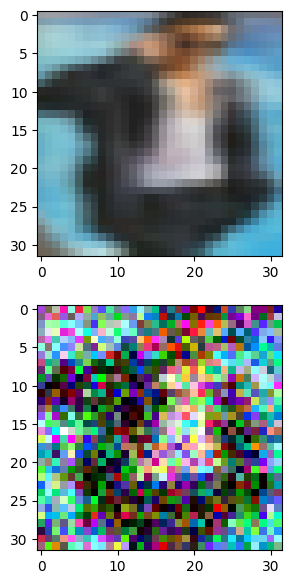

In [ ]:
# take a look at the noise we applied
idx = 1

a = clean_cifar100[noisy_indices[idx]][0]
a = a.transpose(0, 2)
a = a.transpose(0, 1)

b = cifar100[noisy_indices[idx]][0]
b = b.transpose(0, 2)
b = b.transpose(0, 1)

plt2(a,b)

Metrics

In [ ]:
# This block calculates the success at removing the noisy examples.

# torch.cuda.get_device_name(0)
# %cd sas-data-efficient-contrastive-learning/

print(len(cifar100))

print(len(subset_dataset))
# print(subset_dataset.subset_indices)

print(len(noisy_indices))

inter = set(subset_dataset.subset_indices).intersection(set(noisy_indices))

print(len(inter))

print('SAS subset fraction: ' + str(subset_fraction))

print(len(inter) / len(noisy_indices))

print('Percent of noisy examples removed (should be close to 1, definitely greater than 1-|subset_fraction|):')
print(1 - (len(inter) / len(noisy_indices)))

50000
10000
5000
819
SAS subset fraction: 0.2
0.1638
Percent of noisy examples removed (should be close to 1, definitely greater than 1-|subset_fraction|):
0.8362


Save subset to file

In [ ]:
subset_dataset.save_to_file("cifar100-0.2-sas-indices.pkl")